# miniML Tutorial

## Setting up

We begin by importing the required parts of the miniML package. We need to add the path to the miniML core folder to the Python path, and import the MiniTrace and EventDetection classes from miniML. Then, we also import the miniML_plots class from miniML_plot_functions to plot the data.

In [1]:
import sys
sys.path.append('../../core/')
from miniML import MiniTrace, EventDetection
from miniML_plot_functions import miniML_plots

## Running miniML

For the actual data analysis, we first need to load the data and create a miniML *MiniTrace* object. The *MiniTrace* class has different methods for loading from files.Currently accepted file formats are HDF5, Axon ABF and HEKA DAT. 

```{seealso}
Loading data is described in the [Loading data](loading_data.ipynb) notebook
````

In this example, we load the dataset ['mini_data'] from the provided example .h5 file. The data can be scaled for convenience (e.g., to pA). This is optional and has no impact on the analysis. Provide the sampling interval (in seconds, e.g., *sampling=1e-5*) of the recording if the sampling rate is not 50 kHz.

In [2]:
filename = '../../example_data/gc_mini_trace.h5'
scaling = 1e12
unit = 'pA'

# load from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='mini_data',
                               scaling=scaling,
                               sampling=2e-5,
                               unit=unit)

Data can also be loaded from, e.g., Axon binary files (.abf):

```python
filename = '../../example_data/gc_mini_trace.abf'
scaling = 1
unit = 'pA'

# load from ABF file
trace = MiniTrace.from_axon_file(filename=filename,
                                 channel=0,
                                 scaling=scaling,
                                 unit=unit)
```

Let's plot the loaded data:

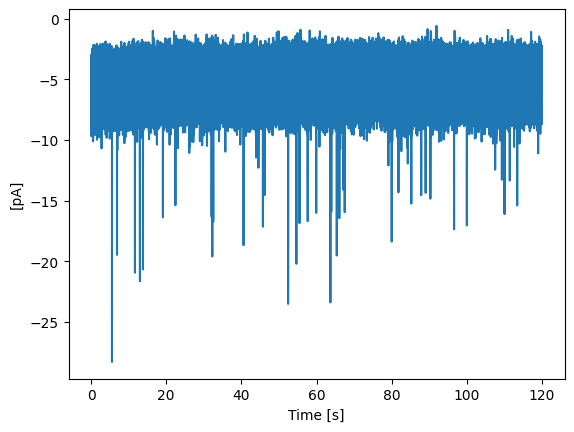

In [3]:
trace.plot_trace()

Next, we need to create and initialize a miniML *EventDetection* object. Required arguments are a miniML MiniTrace object to work on and the path to a miniML model file. Optionally, the threshold for event detection can be adjusted (range, 0–1). The batch_size parameter can be changed to reduce runtime when running on a GPU (caveat: too large batch sizes can cause poor model prediction performance).

In [4]:
win_size = 600
direction = 'negative'

detection = EventDetection(data=trace,
                           model_path='../../models/GC_lstm_model.h5',
                           window_size=win_size,
                           model_threshold=0.5,
                           batch_size=512,
                           event_direction=direction,
                           compile_model=True,
                           verbose=2)

Model loaded from ../../models/GC_lstm_model.h5


To detect events, we have to call the `detect_events()` method. Set the eval flag to **False** if you do not want to analyse the detected events. For the downstream analysis, four parameters can be adjusted:

- **peak_w**: int, default = 5. Determines the minimum width of peaks in the prediction trace.


- **rel_prom_cutoff**: float, default = 0.25. In case multiple peaks in the first derivative are found, this value determines the minimum prominence (relative to the largest prominence) a peak needs to have to be considered an event. For preparations that have no or little to no overlapping events, this value can be set to 1, to find only single peaks.


- **convolve_win**: int, default = 20. Size of the Hann window used to filter the data for detection of event location and event analysis.


- **gradient_convolve_win**: int, default = 2*convolve_win (40 here): Size of the Hann window used to filter the first derivative of the filtered data to determine event locations.


For other data than the one shown here, **convolve_win** and **gradient_convolve_win** are the most crucial to adjust. To check the filter settings, the `plot_gradient_search()` method (see "Inspect the results" section below) can be used.

In [5]:
detection.detect_events(eval=True,
                        peak_w=5,
                        rel_prom_cutoff=0.25,
                        convolve_win=20,
                        gradient_convolve_win=40)

586/586 - 10s - 10s/epoch - 18ms/step

Event statistics:
-------------------------
    Number of events: 43
    Average score: 0.958
    Event frequency: 0.3583 Hz
    Mean amplitude: -9.6757 pA
    Median amplitude: -9.6035 pA
    Std amplitude: 4.2933 pA
    CV amplitude: 0.444
    Mean charge: -0.01395 pC
    CV charge: 0.484
    Mean 10-90 risetime: 0.353 ms
    Mean half decay time: 0.770 ms
    Tau decay: 1.714 ms
-------------------------


## Inspect the results

After the event detection and analysis, we can create some plots. MiniML includes several plotting methods that can be found in the *miniML_plots* class in `miniML_plot_functions.py`. A miniML *EventDetection* object has to be passed as data argument.


`plot_prediction()` shows the model inference trace, optinally together with the data and marked events. Note that we plot a filtered version of the trace in this example.

`plot_event_overlay()` creates a figure with all detected events overlaid, as well as their average and the exponential fit on the average.

`plot_event_histogram()` plots a histogram of event amplitudes (optional: inter-event-intervals). Set *cumulative=True* for a cumulative probability plot.

`plot_gradient_search()` plots the event location search. Top pannel contains the prediction, middle pannel the data and filtered data and lower panel the first derivative and filtered first derivative. Useful if the default filter settings (see above) are not appropriate for your data.


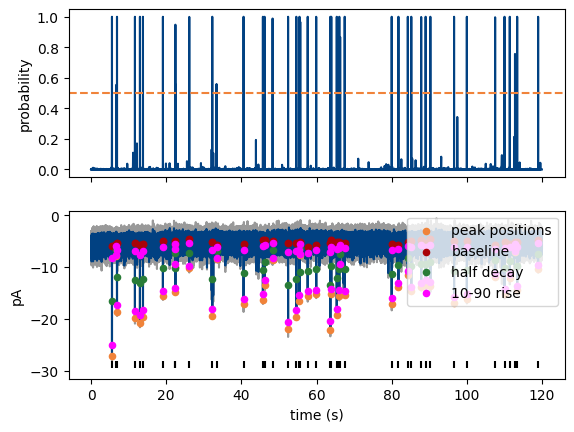

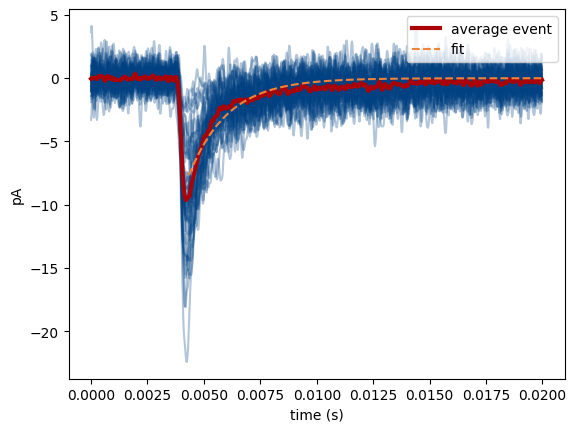

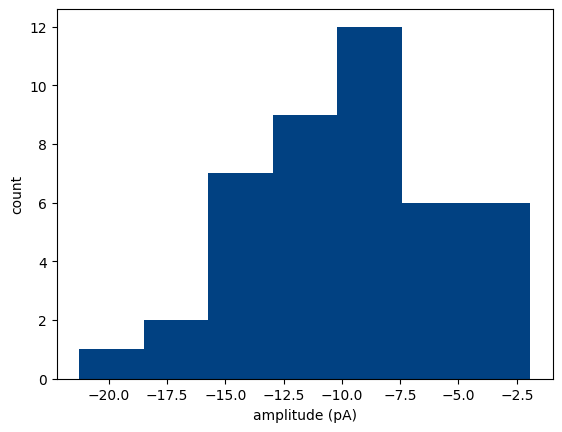

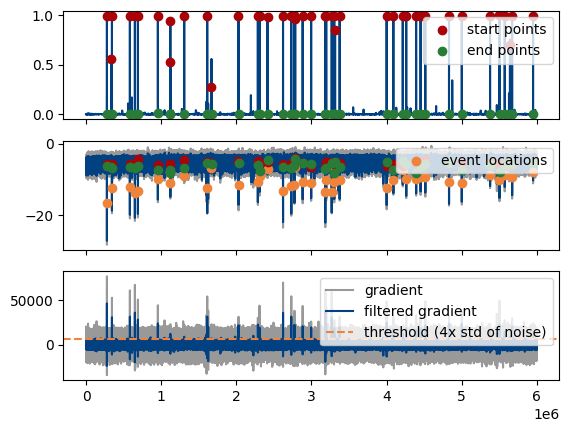

In [6]:
MiniPlots = miniML_plots(data=detection)

MiniPlots.plot_prediction(include_data=True, plot_filtered_prediction=True, plot_filtered_trace=True, plot_event_params=True)
MiniPlots.plot_event_overlay()
MiniPlots.plot_event_histogram(plot='amplitude', cumulative=False)
MiniPlots.plot_gradient_search()

## Save results to file

Finally, we can save the results to file for later use. The `save_to_pickle()` method saves the data in pickle format (essentially a python dictionary). If desired, the mini trace and the generated prediction trace can be saved as well. Note that this will increase file size.

In [7]:
detection.save_to_pickle(filename='../results/gc_mini_trace_results.pickle', 
                         include_prediction=False, 
                         include_data=False)

events saved to ../results/gc_mini_trace_results.pickle


The `save_to_h5()` method saves the detected events and the individual event statistics to a specified HDF5 file. It also includes average results for amplitude, charge, frequency, etc.

In [8]:
detection.save_to_h5(filename='../results/gc_mini_trace_results.h5')

Events saved to ../results/gc_mini_trace_results.h5


In addition, results can be saved in a delimited text format using `save_to_csv()`. This methods takes a filename and saves two .csv files containing event population statistics and individual event statistics, respectively.

In [9]:
detection.save_to_csv(filename='../results/gc_mini_trace_results.csv')

events saved to ../results/gc_mini_trace_results_avgs.csv and ../results/gc_mini_trace_results_individual.csv



```{seealso}
Refer to the documentation in the `miniML.py` file for more details on the saving methods.
````